In [ ]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from google.colab import files
import matplotlib.pyplot as plt
import re
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [ ]:
import warnings

# Filter out warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = 'merged_data_v9.csv'
data = pd.read_csv(file_path)

In [ ]:
data.columns

Index(['customer_no', 'visit_count', 'annual_visit_freq', 'gender', 'age',
       'education', 'hhi', 'children', 'nps', 'overall_experience_score',
       'is_donor', 'first_performance_date', 'first_donation_date',
       'first_donation_amount', 'second_donation_date',
       'second_donation_amount', 'third_donation_date',
       'third_donation_amount', 'survival_time', 'early_donate', 'region',
       'single_viewer', 'avg diff (minutes)', 'media_type_Default Media',
       'media_type_Email', 'media_type_No Media', 'media_type_Postcard',
       'media_type_Subscriber Renewal', 'media_type_Telemarketing',
       'media_type_Web', 'mos_Exchanges', 'mos_Group Sales', 'mos_Internet',
       'mos_Others', 'mos_Patron Services', 'mos_Single Tickets',
       'mos_Subscription', 'mos_TNEW Web', 'sales_channel_Default Channel',
       'sales_channel_Development', 'sales_channel_Email',
       'sales_channel_Exchange', 'sales_channel_Mail', 'sales_channel_Others',
       'sales_channel_Ph

In [ ]:
# Due to collinearity issues, remove a marketing column if the responses are significantly skewed to one category.
threshold = 100

# Media Type
for col in data.columns:
    if col.startswith('media_type') and any(data[col].value_counts() < threshold):
        print(f"Removing column '{col}' due to less than 100 responses in at least one category.")
        data = data.drop(col, axis=1)

# MOS
for col in data.columns:
    if col.startswith('mos') and any(data[col].value_counts() < threshold):
        print(f"Removing column '{col}' due to less than 100 responses in at least one category.")
        data = data.drop(col, axis=1)

# Sales Channel
for col in data.columns:
    if col.startswith('sales_channel') and any(data[col].value_counts() < threshold):
        print(f"Removing column '{col}' due to less than 100 responses in at least one category.")
        data = data.drop(col, axis=1)

Removing column 'media_type_Email' due to less than 100 responses in at least one category.
Removing column 'media_type_Postcard' due to less than 100 responses in at least one category.
Removing column 'media_type_Telemarketing' due to less than 100 responses in at least one category.
Removing column 'media_type_Web' due to less than 100 responses in at least one category.
Removing column 'mos_Exchanges' due to less than 100 responses in at least one category.
Removing column 'mos_Group Sales' due to less than 100 responses in at least one category.
Removing column 'mos_Others' due to less than 100 responses in at least one category.
Removing column 'mos_Patron Services' due to less than 100 responses in at least one category.
Removing column 'sales_channel_Development' due to less than 100 responses in at least one category.
Removing column 'sales_channel_Email' due to less than 100 responses in at least one category.
Removing column 'sales_channel_Exchange' due to less than 100 resp

In [ ]:
# Calculate time between first and second donations
data['time12'] = (pd.to_datetime(data['second_donation_date']) - pd.to_datetime(data['first_donation_date'])).dt.days

data['event12'] = 0
# Set event to 1 if second donation amount is present, otherwise 0
data.loc[data['second_donation_amount'] != 0, 'event12'] = 1

# For customers with no second donation, fill `time` with the max observed time (or end of observation period)
max_time = data['time12'].max()
data['time12'].fillna(max_time, inplace=True)

In [ ]:
data.columns

Index(['customer_no', 'visit_count', 'annual_visit_freq', 'gender', 'age',
       'education', 'hhi', 'children', 'nps', 'overall_experience_score',
       'is_donor', 'first_performance_date', 'first_donation_date',
       'first_donation_amount', 'second_donation_date',
       'second_donation_amount', 'third_donation_date',
       'third_donation_amount', 'survival_time', 'early_donate', 'region',
       'single_viewer', 'avg diff (minutes)', 'media_type_Default Media',
       'media_type_No Media', 'media_type_Subscriber Renewal', 'mos_Internet',
       'mos_Single Tickets', 'mos_Subscription', 'mos_TNEW Web',
       'sales_channel_Default Channel', 'sales_channel_Phone',
       'sales_channel_Web ', 'time12', 'event12'],
      dtype='object')

In [ ]:
# Excluded irrelevant columns from data, including
# 'first_performance_date', 'first_donation_date',
# 'first_donation_amount', 'second_donation_date',
# 'second_donation_amount', 'third_donation_date',
#  'third_donation_amount', 'survival_time', 'early_donate'

model_data = data[['time12', 'event12', 'visit_count', 'annual_visit_freq', 'gender', 'age',
       'education', 'hhi', 'children', 'nps', 'overall_experience_score',
       'region',
       'single_viewer', 'avg diff (minutes)',

        'media_type_Default Media',
        'media_type_No Media',
        'media_type_Subscriber Renewal',
        'mos_Internet',
        'mos_Single Tickets',
       'mos_Subscription',
        'mos_TNEW Web',
        'sales_channel_Default Channel',
       'sales_channel_Phone',
      'sales_channel_Web '  ]]

df = model_data
duration_col = 'time12'
event_col = 'event12'

In [ ]:
cox_model = CoxPHFitter()

# Fit the model
cox_model.fit(df, duration_col=duration_col, event_col=event_col)

# Display the coefficients
print("Cox Regression Coefficients:")
print(cox_model.print_summary())

# Retrieve feature importance (absolute value of coefficients as a proxy)
feature_importance = cox_model.params_.abs().sort_values(ascending=False)
print("\nFeature Importance (Absolute Coefficients):")
print(feature_importance)

Cox Regression Coefficients:


<lifelines.CoxPHFitter: fitted with 1499 total observations, 1187 right-censored observations>
             duration col = 'time12'
                event col = 'event12'
      baseline estimation = breslow
   number of observations = 1499
number of events observed = 312
   partial log-likelihood = -1613.82
         time fit was run = 2024-12-13 03:48:25 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
visit_count                    0.00      1.00      0.01           -0.01            0.02                0.99                1.02
annual_visit_freq              0.09      1.10      0.05           -0.01            0.19                0.99                1.21
gender                        -0.09      0.92      0.12           -0.32            0.14                0.73                1.15
age                           -0.06      0.94      0.10           -0.25            0.14                0.78                1.15
education                      0.22      1.25      0.09            0.05            0.40                1.05                1.50
hhi                            0.20      1.22      0.11           -0.01            0.41                0.99                1.51
children                      -0.06      0.95      0.05           -0.16            0.05                0.85                1.05
nps                            0.00      1.00      0.17           -0.33            0.33                0.72                1.40
overall_experience_score      -0.07      0.94      0.09           -0.25            0.12                0.78                1.12
region                        -0.07      0.93      0.03           -0.13           -0.01                0.88                0.99
single_viewer                 -0.56      0.57      1.02           -2.56            1.43                0.08                4.20
avg diff (minutes)             0.01      1.01      0.00           -0.00            0.01                1.00                1.01
media_type_Default Media      -0.15      0.86      0.29           -0.71            0.41                0.49                1.50
media_type_No Media            0.02      1.02      0.24           -0.44            0.48                0.64                1.62
media_type_Subscriber Renewal  0.10      1.11      0.21           -0.32            0.52                0.73                1.68
mos_Internet                  -0.21      0.81      0.42           -1.02            0.60                0.36                1.83
mos_Single Tickets            -0.26      0.77      0.38           -1.00            0.49                0.37                1.63
mos_Subscription              -0.21      0.81      0.37           -0.95            0.52                0.39                1.68
mos_TNEW Web                  -0.22      0.81      0.46           -1.13            0.69                0.32                2.00
sales_channel_Default Channel  0.18      1.20      0.17           -0.16            0.52                0.85                1.68
sales_channel_Phone            0.11      1.12      0.19           -0.26            0.49                0.77                1.63
sales_channel_Web              0.46      1.58      0.21            0.04            0.88                1.04                2.40

                               cmp to     z    p  -log2(p)
covariate                                                 
visit_count                      0.00  0.75 0.46      1.13
annual_visit_freq                0.00  1.85 0.06      3.96
gender                           0.00 -0.75 0.46      1.13
age                              0.00 -0.57 0.57      0.81
education                        0.00  2.47 0.01      6.20
hhi                              0.00  1.85 0.06      3.96
children                         0.00 -1.05 0.29      1.77
nps                            

None

Feature Importance (Absolute Coefficients):
covariate
single_viewer                    0.562829
sales_channel_Web                0.457940
mos_Single Tickets               0.256847
education                        0.224331
mos_TNEW Web                     0.215480
mos_Subscription                 0.213040
mos_Internet                     0.209328
hhi                              0.198797
sales_channel_Default Channel    0.178880
media_type_Default Media         0.152532
sales_channel_Phone              0.114906
media_type_Subscriber Renewal    0.102800
annual_visit_freq                0.091639
gender                           0.086814
region                           0.069806
overall_experience_score         0.066338
age                              0.056939
children                         0.056531
media_type_No Media              0.020736
avg diff (minutes)               0.005191
visit_count                      0.004309
nps                              0.000483
Name: coef, dtyp

In [ ]:
coef_exp = np.exp(cox_model.params_)

# Define thresholds for feature removal
lower_threshold1 = 0.95
upper_threshold1 = 1.05
lower_threshold2 = 0.7
upper_threshold2 = 1.3

# Identify features to remove
features_to_remove = []
for feature, exp_coef in coef_exp.items():
    if (exp_coef >= lower_threshold1 and exp_coef <= upper_threshold1) or (exp_coef <= lower_threshold2 and exp_coef >= upper_threshold2):
        features_to_remove.append(feature)

print("Features removed:")
print(features_to_remove)

df = df.drop(columns=features_to_remove)


Features removed:
['visit_count', 'nps', 'avg diff (minutes)', 'media_type_No Media']


In [ ]:
cox_model = CoxPHFitter()

# Fit the model
cox_model.fit(df, duration_col=duration_col, event_col=event_col)

# Display the coefficients
print("Cox Regression Coefficients:")
print(cox_model.print_summary())

Cox Regression Coefficients:


<lifelines.CoxPHFitter: fitted with 1499 total observations, 1187 right-censored observations>
             duration col = 'time12'
                event col = 'event12'
      baseline estimation = breslow
   number of observations = 1499
number of events observed = 312
   partial log-likelihood = -1614.92
         time fit was run = 2024-12-13 03:48:26 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
annual_visit_freq              0.11      1.12      0.04            0.04            0.19                1.04                1.21
gender                        -0.08      0.93      0.12           -0.31            0.15                0.74                1.16
age                           -0.04      0.96      0.10           -0.24            0.15                0.79                1.16
education                      0.23      1.25      0.09            0.05            0.40                1.05                1.50
hhi                            0.18      1.20      0.11           -0.02            0.39                0.98                1.48
children                      -0.06      0.94      0.05           -0.17            0.04                0.85                1.04
overall_experience_score      -0.07      0.93      0.09           -0.24            0.10                0.79                1.10
region                        -0.07      0.93      0.03           -0.13           -0.01                0.88                0.99
single_viewer                 -0.46      0.63      1.01           -2.45            1.53                0.09                4.61
media_type_Default Media      -0.17      0.84      0.25           -0.66            0.32                0.52                1.37
media_type_Subscriber Renewal  0.10      1.10      0.16           -0.22            0.42                0.80                1.52
mos_Internet                  -0.22      0.80      0.41           -1.03            0.58                0.36                1.78
mos_Single Tickets            -0.25      0.78      0.38           -0.99            0.49                0.37                1.64
mos_Subscription              -0.20      0.82      0.37           -0.92            0.52                0.40                1.69
mos_TNEW Web                  -0.22      0.80      0.46           -1.12            0.68                0.33                1.98
sales_channel_Default Channel  0.20      1.22      0.17           -0.13            0.53                0.88                1.71
sales_channel_Phone            0.13      1.13      0.19           -0.24            0.49                0.78                1.64
sales_channel_Web              0.44      1.56      0.21            0.03            0.86                1.03                2.35

                               cmp to     z      p  -log2(p)
covariate                                                   
annual_visit_freq                0.00  3.00 <0.005      8.52
gender                           0.00 -0.67   0.50      0.99
age                              0.00 -0.43   0.67      0.59
education                        0.00  2.52   0.01      6.41
hhi                              0.00  1.74   0.08      3.60
children                         0.00 -1.19   0.23      2.09
overall_experience_score         0.00 -0.80   0.43      1.23
region                           0.00 -2.43   0.02      6.05
single_viewer                    0.00 -0.45   0.65      0.62
media_type_Default Media         0.00 -0.69   0.49      1.03
media_type_Subscriber Renewal    0.00  0.61   0.54      0.88
mos_Internet                     0.00 -0.55   0.58      0.78
mos_Single Tickets               0.00 -0.66   0.51      0.97
mos_Subscription                 0.00 -0.54   0.59      0.76
mos_TNEW Web                     0.00 -0.48   0.63      0.66
sales_channel_Default Channel    0.00

None


In [ ]:
# Define train-test split
train_df = df.sample(frac=0.8, random_state=42)  # 80% for training
test_df = df.drop(train_df.index)  # Remaining 20% for testing

# Fit the Cox model on the training dataset
cox_model = CoxPHFitter()
cox_model.fit(train_df, duration_col=duration_col, event_col=event_col)
print(cox_model.print_summary())

# Calculate training error
train_cindex = concordance_index(
    train_df[duration_col],
    -cox_model.predict_partial_hazard(train_df),
    train_df[event_col]
)
training_error = train_cindex

# Calculate testing error
test_cindex = concordance_index(
    test_df[duration_col],
    -cox_model.predict_partial_hazard(test_df),
    test_df[event_col]
)
test_error =  test_cindex

print("Training Error:", training_error)
print("Testing Error:", test_error)

<lifelines.CoxPHFitter: fitted with 1199 total observations, 938 right-censored observations>
             duration col = 'time12'
                event col = 'event12'
      baseline estimation = breslow
   number of observations = 1199
number of events observed = 261
   partial log-likelihood = -1303.30
         time fit was run = 2024-12-13 03:48:27 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
annual_visit_freq              0.14      1.15      0.04            0.06            0.22                1.07                1.25
gender                        -0.10      0.91      0.13           -0.35            0.15                0.70                1.17
age                           -0.02      0.98      0.11           -0.22            0.19                0.80                1.21
education                      0.17      1.19      0.10           -0.03            0.37                0.97                1.45
hhi                            0.28      1.32      0.12            0.04            0.52                1.05                1.68
children                      -0.08      0.92      0.06           -0.19            0.04                0.82                1.04
overall_experience_score      -0.12      0.89      0.09           -0.30            0.06                0.74                1.06
region                        -0.07      0.93      0.03           -0.13           -0.01                0.88                0.99
single_viewer                 -0.49      0.61      1.02           -2.49            1.50                0.08                4.48
media_type_Default Media       0.04      1.04      0.28           -0.51            0.58                0.60                1.79
media_type_Subscriber Renewal  0.10      1.11      0.18           -0.25            0.45                0.78                1.57
mos_Internet                  -0.03      0.97      0.45           -0.91            0.85                0.40                2.34
mos_Single Tickets            -0.13      0.88      0.41           -0.92            0.67                0.40                1.96
mos_Subscription              -0.03      0.97      0.39           -0.80            0.73                0.45                2.08
mos_TNEW Web                  -0.31      0.73      0.50           -1.28            0.67                0.28                1.95
sales_channel_Default Channel  0.06      1.06      0.18           -0.30            0.42                0.74                1.52
sales_channel_Phone            0.05      1.05      0.20           -0.34            0.44                0.71                1.55
sales_channel_Web              0.42      1.52      0.24           -0.04            0.89                0.96                2.43

                               cmp to     z      p  -log2(p)
covariate                                                   
annual_visit_freq                0.00  3.54 <0.005     11.29
gender                           0.00 -0.76   0.45      1.17
age                              0.00 -0.17   0.87      0.20
education                        0.00  1.70   0.09      3.50
hhi                              0.00  2.33   0.02      5.65
children                         0.00 -1.36   0.17      2.52
overall_experience_score         0.00 -1.32   0.19      2.42
region                           0.00 -2.16   0.03      5.03
single_viewer                    0.00 -0.48   0.63      0.67
media_type_Default Media         0.00  0.13   0.90      0.15
media_type_Subscriber Renewal    0.00  0.57   0.57      0.81
mos_Internet                     0.00 -0.06   0.95      0.07
mos_Single Tickets               0.00 -0.31   0.76      0.40
mos_Subscription                 0.00 -0.09   0.93      0.11
mos_TNEW Web                     0.00 -0.62   0.54      0.90
sales_channel_Default Channel    0.00 

None
Training Error: 0.6027944688390725
Testing Error: 0.5813139472267097


Removed feature 'annual_visit_freq', training C-index: 0.5820, testing C-index: 0.5937
Removed feature 'overall_experience_score', training C-index: 0.5817, testing C-index: 0.6093
Removed feature 'mos_TNEW Web', training C-index: 0.5819, testing C-index: 0.6142
Removed feature 'mos_Subscription', training C-index: 0.5834, testing C-index: 0.6195
Removed feature 'hhi', training C-index: 0.5762, testing C-index: 0.6233
Removed feature 'single_viewer', training C-index: 0.5762, testing C-index: 0.6239
Removed feature 'sales_channel_Default Channel', training C-index: 0.5750, testing C-index: 0.6236
Removed feature 'mos_Single Tickets', training C-index: 0.5756, testing C-index: 0.6247
Removed feature 'age', training C-index: 0.5753, testing C-index: 0.6252
Removed feature 'mos_Internet', training C-index: 0.5753, testing C-index: 0.6244
Removed feature 'media_type_Default Media', training C-index: 0.5740, testing C-index: 0.6228


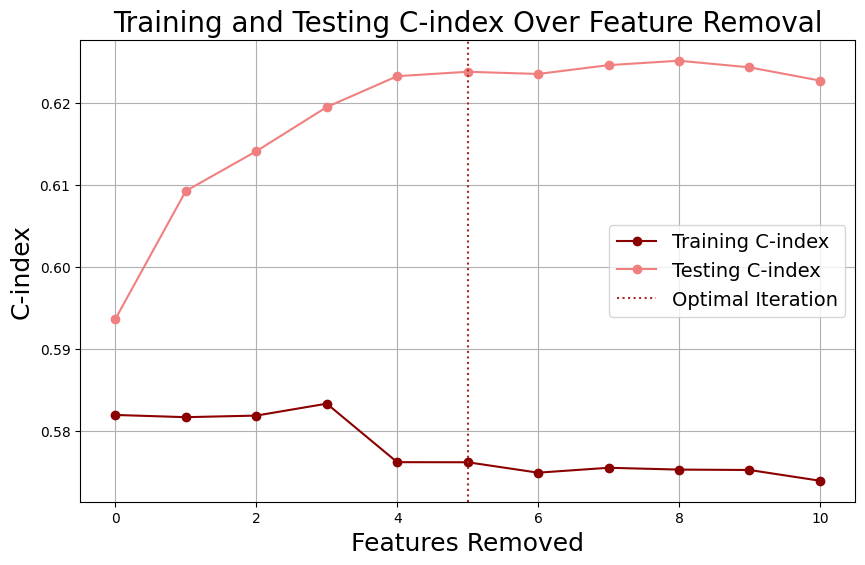

Final Selected Features: ['children', 'education', 'gender', 'media_type_Subscriber Renewal', 'region', 'sales_channel_Phone', 'sales_channel_Web ']


In [ ]:
# Standardize the numerical features
numerical_cols = df.columns.difference([duration_col, event_col])
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Initialize variables for tracking
remaining_features = list(numerical_cols)
train_cindex_history = []
val_cindex_history = []
features_removed = []

# Backward feature selection
while len(remaining_features) > 7:  # Stop when 7 features remain
    feature_cindex = {}

    for feature in remaining_features:
        temp_features = [f for f in remaining_features if f != feature]
        train_subset = train_df[[duration_col, event_col] + temp_features]
        test_subset = test_df[[duration_col, event_col] + temp_features]

        try:
            cph = CoxPHFitter(penalizer=0.1)  # Apply penalizer
            cph.fit(train_subset, duration_col=duration_col, event_col=event_col)

            # Calculate training and testing C-index
            train_cindex = concordance_index(train_subset[duration_col],
                                             -cph.predict_partial_hazard(train_subset),
                                             train_subset[event_col])
            test_cindex = concordance_index(test_subset[duration_col],
                                           -cph.predict_partial_hazard(test_subset),
                                           test_subset[event_col])

            feature_cindex[feature] = (train_cindex, test_cindex)
        except Exception as e:
            print(f"Error removing feature {feature}: {e}")

    # Find the feature whose removal has the smallest negative impact on test C-index
    best_feature_to_remove = max(feature_cindex, key=lambda f: feature_cindex[f][1])
    best_train_cindex, best_val_cindex = feature_cindex[best_feature_to_remove]

    # Track C-index and removed features
    train_cindex_history.append(best_train_cindex)
    val_cindex_history.append(best_val_cindex)
    features_removed.append(best_feature_to_remove)

    # Remove the feature
    remaining_features.remove(best_feature_to_remove)
    print(f"Removed feature '{best_feature_to_remove}', training C-index: {best_train_cindex:.4f}, testing C-index: {best_val_cindex:.4f}")

# Plot the C-index history
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_cindex_history)), train_cindex_history, label="Training C-index", marker="o", color="darkred")
plt.plot(range(len(val_cindex_history)), val_cindex_history, label="Testing C-index", marker="o", color="lightcoral")

# Add a dotted line at chosen iteration
optimal_iteration = 5
plt.axvline(x=optimal_iteration, color='brown', linestyle=':')

# Create a custom legend entry for the dotted line
custom_line = Line2D([0], [0], color='brown', linestyle=':', label="Optimal Iteration")

# Add the custom legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(custom_line)
labels.append("Optimal Iteration")

plt.xlabel("Features Removed", fontsize=18)
plt.ylabel("C-index", fontsize=18)
plt.title("Training and Testing C-index Over Feature Removal", fontsize=20)
plt.legend(handles=handles, labels=labels, fontsize=14)
plt.grid(True)
plt.show()

# Final selected features
print("Final Selected Features:", remaining_features)



In [ ]:
# Restore features removed after the optimal iteration
restored_features = features_removed[optimal_iteration:]  # Features removed after optimal iteration
remaining_features.extend(restored_features)  # Add them back to the remaining features

# Ensure the feature list is unique and sorted (if needed)
remaining_features = sorted(set(remaining_features))

print("Features restored after optimal iteration:", restored_features)
print("Final Selected Features after restoration:", remaining_features)


Features restored after optimal iteration: ['single_viewer', 'sales_channel_Default Channel', 'mos_Single Tickets', 'age', 'mos_Internet', 'media_type_Default Media']
Final Selected Features after restoration: ['age', 'children', 'education', 'gender', 'media_type_Default Media', 'media_type_Subscriber Renewal', 'mos_Internet', 'mos_Single Tickets', 'region', 'sales_channel_Default Channel', 'sales_channel_Phone', 'sales_channel_Web ', 'single_viewer']


# Ideal Customer Profile

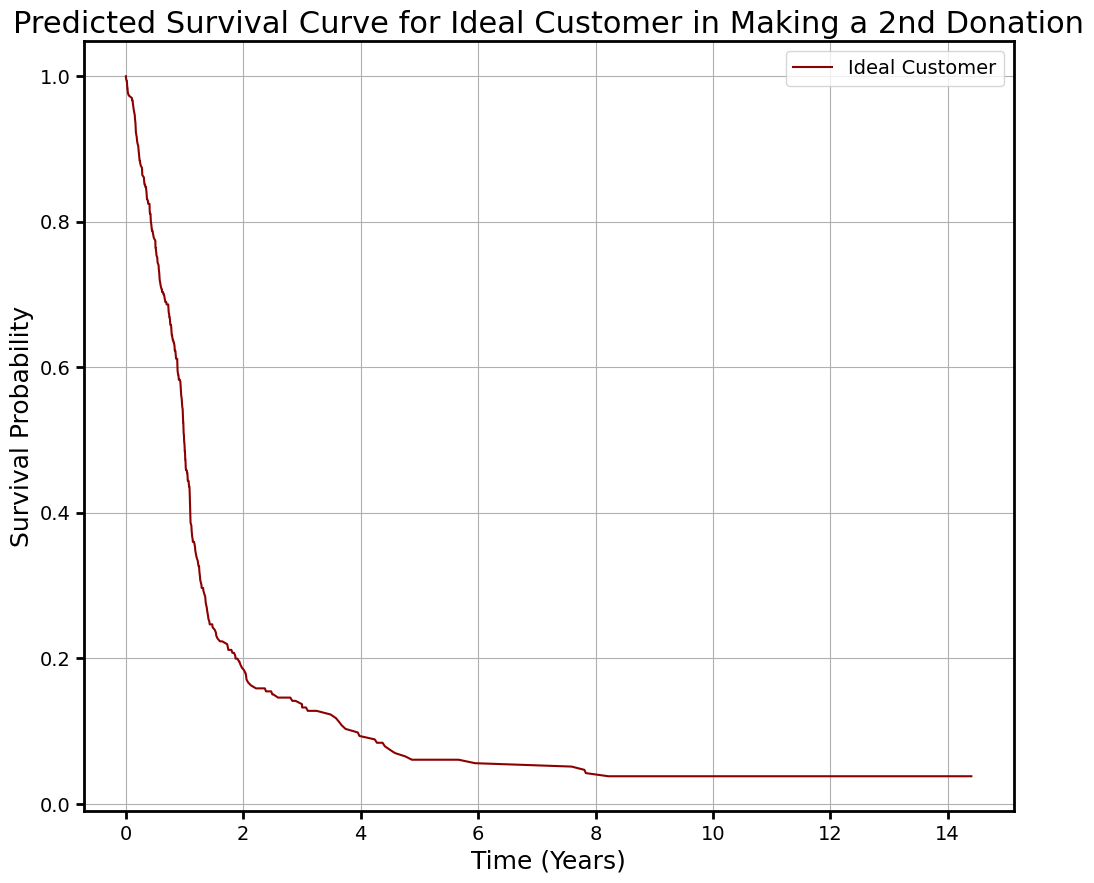

Ideal Customer: {'age': 1, 'children': 0, 'education': 1, 'gender': 0, 'media_type_Default Media': 0, 'media_type_Subscriber Renewal': 1, 'mos_Internet': 1, 'mos_Single Tickets': 1, 'region': 0, 'sales_channel_Default Channel': 0, 'sales_channel_Phone': 0, 'sales_channel_Web ': 1, 'single_viewer': 0}


In [ ]:
def create_fastest_donation_customer(coxph_model, optimal_features):
    """
    Create an ideal customer with feature values that maximize the hazard ratio
    (minimize survival time) and plot their predicted survival curve.

    Parameters:
    - coxph_model: Trained CoxPHFitter model.
    - optimal_features: List of selected features used in the Cox model.

    Returns:
    - ideal_customer: Dict containing the feature values for the ideal customer.
    - survival_function: Pandas DataFrame of the predicted survival function.
    """

    # Get the coefficients of the trained Cox model
    coefs = coxph_model.params_

    # Create an ideal customer with feature values that maximize hazard
    ideal_customer = {}
    for feature in optimal_features:
        if feature in coefs.index:
            # Positive coefficient: Set to high value (maximize hazard)
            # Negative coefficient: Set to low value (minimize hazard)
            ideal_customer[feature] = 1 if coefs[feature] > 0 else 0
        else:
            # Handle features that were not included in the model (set to 0)
            ideal_customer[feature] = 0

    # Convert to a DataFrame for prediction
    ideal_customer_df = pd.DataFrame([ideal_customer])

    # Predict survival function for the ideal customer
    survival_function = coxph_model.predict_survival_function(ideal_customer_df)

    # Convert time index to years
    survival_function.index = survival_function.index / 365  # Assuming time is in days

    # Plot the survival curve
    plt.figure(figsize=(12, 10))
    plt.plot(survival_function.index, survival_function.values[:, 0], label='Ideal Customer', color='darkred')
    # Make axes bolder
    ax = plt.gca()  # Get current axis
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=6, labelsize=14)  # Bold ticks

    plt.xlabel('Time (Years)', fontsize=18)  # Increased font size
    plt.ylabel('Survival Probability', fontsize=18)  # Increased font size
    plt.xticks(fontsize=14)  # Increased x-tick font size
    plt.yticks(fontsize=14)  # Increased y-tick font size
    plt.title('Predicted Survival Curve for Ideal Customer in Making a 2nd Donation', fontsize=22)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

    return ideal_customer, survival_function

# Train the final Cox model with the updated features
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train_df[[duration_col, event_col] + remaining_features], duration_col=duration_col, event_col=event_col)

# Create the fastest donation customer based on the final model
ideal_customer, survival_function = create_fastest_donation_customer(cph, remaining_features)

# Print the feature values for the ideal customer
print("Ideal Customer:", ideal_customer)



# Input Sample Customer

Input any sample of customer features to predict their survival in making a 2nd donation

In [ ]:
sample_customer = {
     'visit_count': 36,
     'annual_visit_freq': 2.6,
     'gender': 1,
     'age': 2,
     'education': 1,
     'hhi': 2,
     'children': 0,
     'nps': 2,
     'overall_experience_score': 4,
     'region':  1,
     'single_viewer': 0,
     'avg diff (minutes)': 39,
     'media_type_Default Media': 0,
     'media_type_Email': 0,
     'media_type_No Media': 0,
     'media_type_Postcard': 0,
     'media_type_Telemarketing': 0,
     'media_type_Web': 0,
     'media_type_Subscriber Renewal': 0,
     'mos_Exchanges': 0,
     'mos_Group Sales': 0,
     'mos_Internet': 0,
     'mos_Patron Services': 0,
     'mos_Single Tickets': 0,
     'mos_Subscription': 1,
     'mos_TNEW Web': 0,
     'sales_channel_Default Channel': 0,
     'sales_channel_Development': 1,
     'sales_channel_Email': 0,
     'sales_channel_Mail': 0,
     'sales_channel_Phone': 0,
     'sales_channel_Web ': 0
}

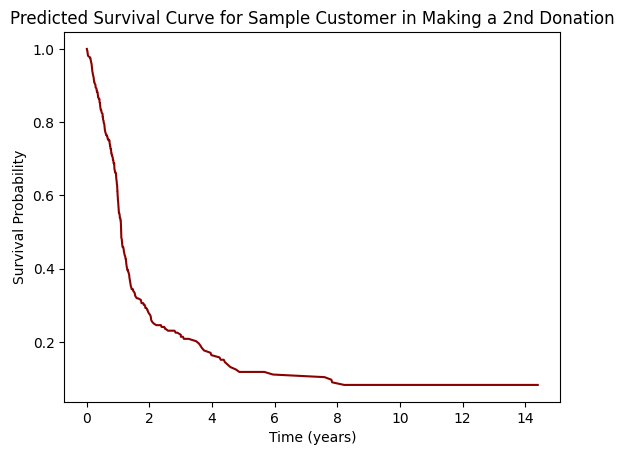

In [ ]:
# Get the features used in the final Cox model
final_model_features = cph.params_.index.tolist()

# Remove features from sample_customer that are not in the final model
for feature in list(sample_customer.keys()):  # Iterate over a copy of keys to avoid errors
    if feature not in final_model_features:
        del sample_customer[feature]

# Recreate the DataFrame from the updated sample customer data
sample_customer_df = pd.DataFrame([sample_customer])

# Predict the survival function
sample_survival_predictions = cph.predict_survival_function(sample_customer_df)

# Convert time index to years (assuming 365 days per year)
sample_survival_predictions.index = sample_survival_predictions.index / 365

# Plot the survival function for the sample customer
ax = sample_survival_predictions.plot(color='darkred', legend=False)  # Disable the legend
plt.title('Predicted Survival Curve for Sample Customer in Making a 2nd Donation')
plt.xlabel('Time (years)')
plt.ylabel('Survival Probability')

# Show the plot without a legend
plt.show()


